# <span style="color:#DC143C">Part 2</span>

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from xgboost import XGBClassifier

from supertree import SuperTree

import pickle

lakers_purple = '#552583'
lakers_orange = '#FDB927'
SEED = 24

In [2]:
from sklearn import preprocessing, model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
data1 = pd.read_csv("output1.csv")
data = data1.copy()

In [5]:
data.head()

,action_type,combined_shot_type,loc_x,loc_y,period,playoffs,season,shot_distance,shot_made_flag,shot_zone_area,shot_zone_basic,opponent,remaining_time,2PT Field Goal,3PT Field Goal,home_court,injury
0,Jump Shot,Jump Shot,-157,0,1,0,2000,15,0.0,Left Side(L),Mid-Range,POR,622,True,False,0,0
1,Jump Shot,Jump Shot,-101,135,1,0,2000,16,1.0,Left Side Center(LC),Mid-Range,POR,465,True,False,0,0
2,Jump Shot,Jump Shot,138,175,1,0,2000,22,0.0,Right Side Center(RC),Mid-Range,POR,412,True,False,0,0
3,Driving Dunk Shot,Dunk,0,0,2,0,2000,0,1.0,Center(C),Restricted Area,POR,379,True,False,0,0
4,Jump Shot,Jump Shot,-145,-11,3,0,2000,14,0.0,Left Side(L),Mid-Range,POR,572,True,False,0,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25697 entries, 0 to 25696
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         25697 non-null  object 
 1   combined_shot_type  25697 non-null  object 
 2   loc_x               25697 non-null  int64  
 3   loc_y               25697 non-null  int64  
 4   period              25697 non-null  int64  
 5   playoffs            25697 non-null  int64  
 6   season              25697 non-null  int64  
 7   shot_distance       25697 non-null  int64  
 8   shot_made_flag      25697 non-null  float64
 9   shot_zone_area      25697 non-null  object 
 10  shot_zone_basic     25697 non-null  object 
 11  opponent            25697 non-null  object 
 12  remaining_time      25697 non-null  int64  
 13  2PT Field Goal      25697 non-null  bool   
 14  3PT Field Goal      25697 non-null  bool   
 15  home_court          25697 non-null  int64  
 16  inju

In [7]:
y = data['shot_made_flag']
X = data
#X.info()

# <span style="font-size:24px;color:#552583">Training-test-validation split</span>

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = SEED, stratify = y)

In [9]:
print("Trening set (shape): ",X_train.shape)
print("Test set (shape): ",X_test.shape)

Trening set (shape):  (21842, 17)
Test set (shape):  (3855, 17)


In [10]:
print(type(X_train), type(X_test))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


# <span style="font-size:24px;color:#552583">Stratification: visualized</span>

12097 9745 2135 1720


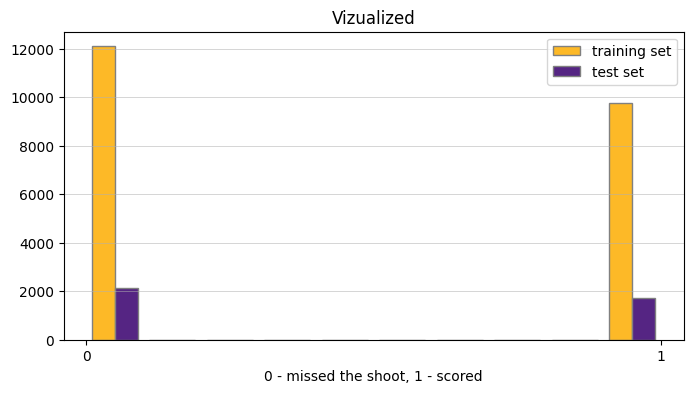

In [11]:
misses_train = np.sum(y_train==0)
scores_train = np.sum(y_train==1)
misses_test = np.sum(y_test==0)
scores_test = np.sum(y_test==1)
print(misses_train, scores_train, misses_test, scores_test)
plt.figure(figsize = (8,4))

plt.title('Vizualized')
plt.xticks([0,1])
plt.xlabel('0 - missed the shoot, 1 - scored')
plt.hist([y_train, y_test], color=[lakers_orange, lakers_purple], label=['training set', 'test set'], edgecolor='gray')
plt.legend(loc='best')
plt.grid(axis = 'y', linewidth = 0.37)

plt.show()

# <span style="font-size:24px;color:#552583">Transform to numerical values</span>

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21842 entries, 5140 to 16772
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         21842 non-null  object 
 1   combined_shot_type  21842 non-null  object 
 2   loc_x               21842 non-null  int64  
 3   loc_y               21842 non-null  int64  
 4   period              21842 non-null  int64  
 5   playoffs            21842 non-null  int64  
 6   season              21842 non-null  int64  
 7   shot_distance       21842 non-null  int64  
 8   shot_made_flag      21842 non-null  float64
 9   shot_zone_area      21842 non-null  object 
 10  shot_zone_basic     21842 non-null  object 
 11  opponent            21842 non-null  object 
 12  remaining_time      21842 non-null  int64  
 13  2PT Field Goal      21842 non-null  bool   
 14  3PT Field Goal      21842 non-null  bool   
 15  home_court          21842 non-null  int64  
 16  injury

# <span style="font-size:24px;color:#552583">action_type : shot_made : visualised</span>

In [13]:
len(X_train.action_type.unique())

53

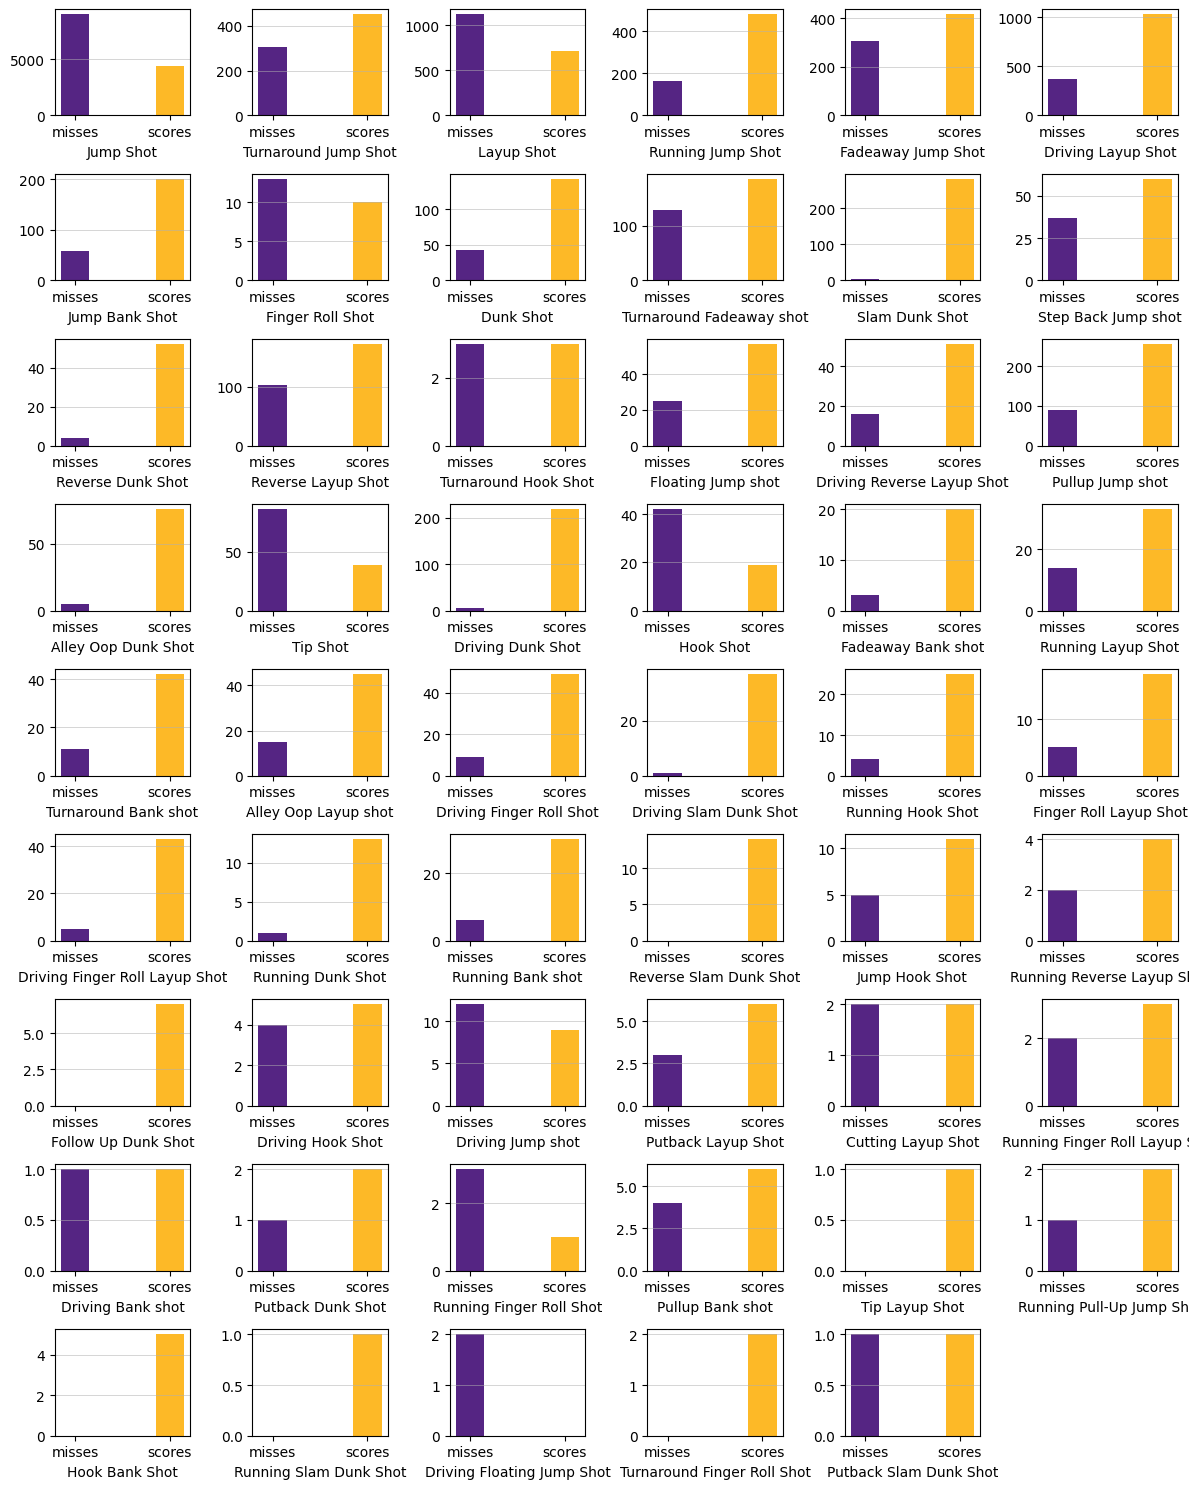

In [14]:
action_type_unique = X_train.action_type.unique()
rows = 9
cols = 6
fig, axes = plt.subplots(rows, cols, figsize=(12,15))
axes = axes.flatten()
i=0
for x in action_type_unique:
    curr_scored = np.sum(X_train[X_train['action_type'] == x].shot_made_flag == 1) 
    curr_missed = np.sum(X_train[X_train['action_type'] == x].shot_made_flag == 0)
    axes[i].set_xticks([0,1])
    axes[i].set_xlabel(x)
    axes[i].bar(['misses', 'scores'], [curr_missed, curr_scored], color = [lakers_purple, lakers_orange], width = 0.3, align = 'center')
    axes[i].grid(axis = 'y', linewidth = 0.37)
    i += 1

fig.delaxes(axes[53])

plt.tight_layout()
plt.show()


In [15]:
#We will replace action_type with probability of scoring on train set

In [16]:
action_types_train = X_train.action_type.unique() 

In [17]:
len(action_types_train)

53

In [18]:
dict = {}
dict_scores = {}
dict_misses = {}
for item in action_types_train:
    #print(item)
    dict[item] = sum(X_train['action_type'] == item)
    dict_scores[item] = X_train.loc[X_train['action_type'] == item, 'shot_made_flag'].sum()
    dict_misses[item] = X_train.loc[(X_train['action_type'] == item) & (X_train['shot_made_flag'] == 0), 'shot_made_flag'].count()
 

#print(dict)
#print()
#print(dict_scores)
#print()
#print(dict_misses)

In [19]:
tmp = X_train['action_type'].apply(lambda x: dict_scores[x] / dict[x] if dict[x] != 0 else float('0.5'))


In [20]:
X_train['action_type_probability'] = tmp

In [21]:
#X_train.info()

In [22]:
tmp2 = X_test['action_type'].apply(lambda x: dict_scores[x] / dict[x] if x in dict else float('0.5'))

In [23]:
X_test['action_type_probability'] = tmp2

In [24]:
#X_test.info()

# <span style="font-size:24px;color:#552583">combined_shot_type : shot_made : visualised</span>

In [25]:
len(X_train.combined_shot_type.unique())

6

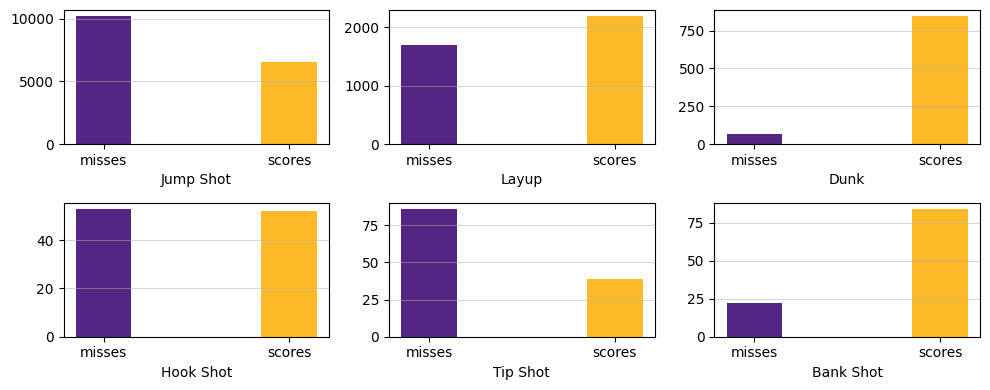

In [26]:
cs_type_unique = X_train.combined_shot_type.unique()
rows = 2
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(10,4))
axes = axes.flatten()
i = 0
for x in cs_type_unique:
    curr_scored = np.sum(X_train[X_train['combined_shot_type'] == x].shot_made_flag == 1) 
    curr_missed = np.sum(X_train[X_train['combined_shot_type'] == x].shot_made_flag == 0)
    axes[i].set_xticks([0,1])
    axes[i].set_xlabel(x)
    axes[i].bar(['misses', 'scores'], [curr_missed, curr_scored], color = [lakers_purple, lakers_orange], width = 0.3, align = 'center')
    axes[i].grid(axis = 'y', linewidth = 0.37)
    i += 1

plt.tight_layout()
plt.show()

In [27]:
combined_types_train = X_train.combined_shot_type.unique()

In [28]:
dict.clear()
dict_scores.clear()
dict_misses.clear()

dict = {}
dict_scores = {}
dict_misses = {}
for item in combined_types_train:
    #print(item)
    dict[item] = sum(X_train['combined_shot_type'] == item)
    dict_scores[item] = X_train.loc[X_train['combined_shot_type'] == item, 'shot_made_flag'].sum()
    dict_misses[item] = X_train.loc[(X_train['combined_shot_type'] == item) & (X_train['shot_made_flag'] == 0), 'shot_made_flag'].count()
 

#print(dict)
#print()
#print(dict_scores)
#print()
#print(dict_misses)

In [29]:
tmp = X_train['combined_shot_type'].apply(lambda x: dict_scores[x] / dict[x] if dict[x] != 0 else float('0.5'))
X_train['combined_type_probability'] = tmp
#X_train.info()

In [30]:
tmp2 = X_test['combined_shot_type'].apply(lambda x: dict_scores[x] / dict[x] if x in dict else float('0.5'))
X_test['combined_type_probability'] = tmp2
#X_test.info()

# <span style="font-size:24px;color:#552583">opponent : shot_made : visualised</span>

In [31]:
len(X_train.opponent.unique())

33

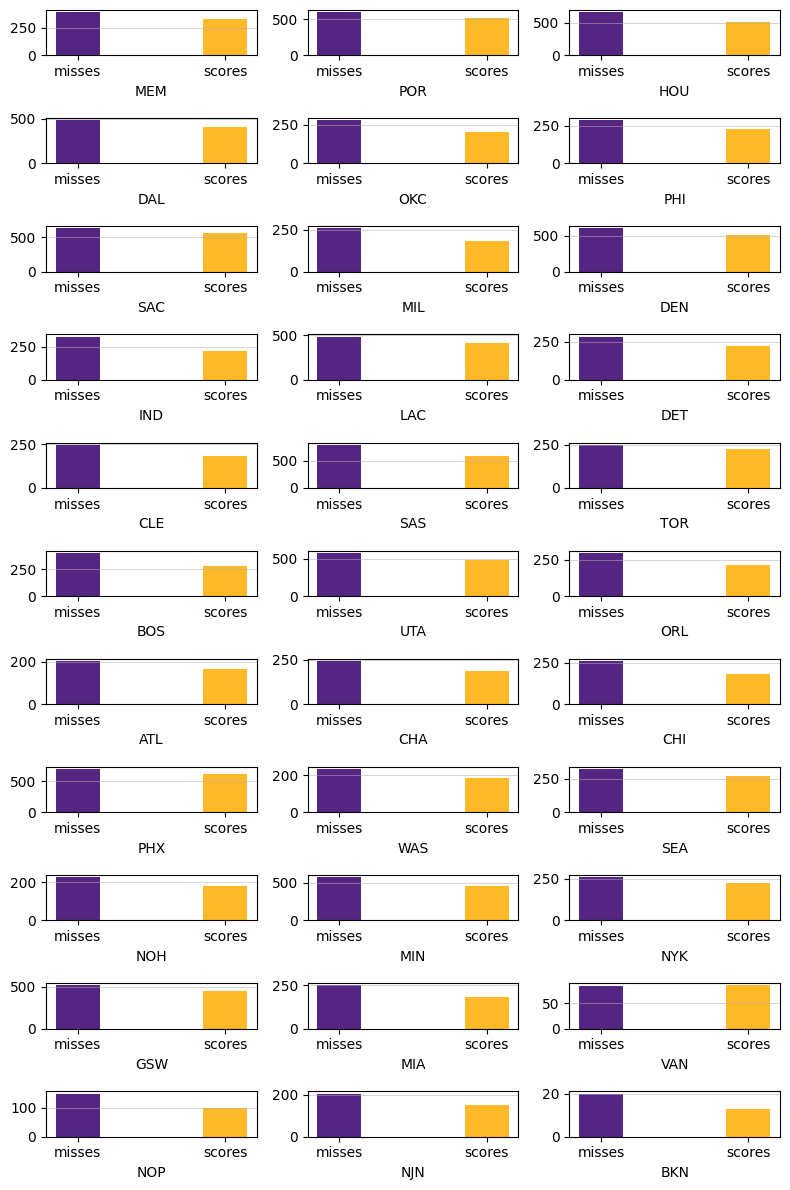

In [32]:
opponent_unique = X_train.opponent.unique()
rows = 11
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(8,12))
axes = axes.flatten()
i=0
for x in opponent_unique:
    curr_scored = np.sum(X_train[X_train['opponent'] == x].shot_made_flag == 1) 
    curr_missed = np.sum(X_train[X_train['opponent'] == x].shot_made_flag == 0)
    #print(x, curr_scored, curr_missed)
    axes[i].set_xticks([0,1])
    axes[i].set_xlabel(x)

    axes[i].bar(['misses', 'scores'], [curr_missed, curr_scored], color = [lakers_purple, lakers_orange], width = 0.3, align = 'center')
    

    axes[i].grid(axis = 'y', linewidth = 0.37)
    i += 1


plt.tight_layout()
plt.show()


In [33]:
opponents_train = X_train.opponent.unique()

In [34]:
dict.clear()
dict_scores.clear()
dict_misses.clear()

dict = {}
dict_scores = {}
dict_misses = {}
for item in opponents_train:
    #print(item)
    dict[item] = sum(X_train['opponent'] == item)
    dict_scores[item] = X_train.loc[X_train['opponent'] == item, 'shot_made_flag'].sum()
    dict_misses[item] = X_train.loc[(X_train['opponent'] == item) & (X_train['shot_made_flag'] == 0), 'shot_made_flag'].count()
 

In [35]:
tmp = X_train['opponent'].apply(lambda x: dict_scores[x] / dict[x] if x in dict else float('0.5'))
X_train['opponent_probability'] = tmp
#X_train.info()

In [36]:
tmp3 = X_test['opponent'].apply(lambda x: dict_scores[x] / dict[x] if x in dict else float('0.5'))
X_test['opponent_probability'] = tmp3
#X_test.info()

# <span style="font-size:24px;color:#552583">shot_zone_area</span>

In [37]:
area_train = X_train.shot_zone_area.unique()
print(area_train)

['Left Side Center(LC)' 'Center(C)' 'Right Side(R)'
 'Right Side Center(RC)' 'Left Side(L)' 'Back Court(BC)']


In [38]:
dict = {}
dict_scores = {}
dict_misses = {}
for item in area_train:
    #print(item)
    dict[item] = sum(X_train['shot_zone_area'] == item)
    dict_scores[item] = X_train.loc[X_train['shot_zone_area'] == item, 'shot_made_flag'].sum()
    dict_misses[item] = X_train.loc[(X_train['shot_zone_area'] == item) & (X_train['shot_made_flag'] == 0), 'shot_made_flag'].count()
 

In [39]:
tmp = X_train['shot_zone_area'].apply(lambda x: dict_scores[x] / dict[x] if x in dict else float('0.5'))
X_train['area_probability'] = tmp
#X_train.info()

In [40]:
tmp3 = X_test['shot_zone_area'].apply(lambda x: dict_scores[x] / dict[x] if x in dict else float('0.5'))
X_test['area_probability'] = tmp3
#X_test.info()

# <span style="font-size:24px;color:#552583">shot_zone_basic</span>

In [41]:
zone_basic_train = X_train.shot_zone_basic.unique()
print(area_train)

['Left Side Center(LC)' 'Center(C)' 'Right Side(R)'
 'Right Side Center(RC)' 'Left Side(L)' 'Back Court(BC)']


In [44]:
dict = {}
dict_scores = {}
dict_misses = {}
for item in zone_basic_train:
    #print(item)
    dict[item] = sum(X_train['shot_zone_basic'] == item)
    dict_scores[item] = X_train.loc[X_train['shot_zone_basic'] == item, 'shot_made_flag'].sum()
    dict_misses[item] = X_train.loc[(X_train['shot_zone_basic'] == item) & (X_train['shot_made_flag'] == 0), 'shot_made_flag'].count()
 

In [45]:
tmp = X_train['shot_zone_basic'].apply(lambda x: dict_scores[x] / dict[x] if x in dict else float('0.5'))
X_train['zone_probability'] = tmp
#X_train.info()

In [46]:
tmp3 = X_test['shot_zone_basic'].apply(lambda x: dict_scores[x] / dict[x] if x in dict else float('0.5'))
X_test['zone_probability'] = tmp3
#X_test.info()

# <span style="font-size:24px;color:#552583">Dropping columns</span>

In [47]:
y_train = X_train['shot_made_flag']
y_test = X_test['shot_made_flag']
X_train.drop(columns = ['action_type', 'combined_shot_type', 'opponent','shot_made_flag','shot_zone_area','shot_zone_basic'], inplace=True)
X_test.drop(columns = ['action_type', 'combined_shot_type', 'opponent','shot_made_flag','shot_zone_area','shot_zone_basic'], inplace=True)

In [48]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21842 entries, 5140 to 16772
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   loc_x                      21842 non-null  int64  
 1   loc_y                      21842 non-null  int64  
 2   period                     21842 non-null  int64  
 3   playoffs                   21842 non-null  int64  
 4   season                     21842 non-null  int64  
 5   shot_distance              21842 non-null  int64  
 6   remaining_time             21842 non-null  int64  
 7   2PT Field Goal             21842 non-null  bool   
 8   3PT Field Goal             21842 non-null  bool   
 9   home_court                 21842 non-null  int64  
 10  injury                     21842 non-null  int64  
 11  action_type_probability    21842 non-null  float64
 12  combined_type_probability  21842 non-null  float64
 13  opponent_probability       21842 non-null  float

In [49]:
feature_names = X_train.columns.tolist()

In [50]:
pd.DataFrame(X_train).to_csv('X_train1.csv', index=False)
pd.DataFrame(X_test).to_csv('X_test1.csv', index=False)
pd.DataFrame(y_train).to_csv('y_train1.csv', index=False)
pd.DataFrame(y_test).to_csv('y_test1.csv', index=False)

# <span style="font-size:28px;color:#552583">1. Logistic regression</span>

In [51]:
grid_model = Pipeline(steps=[('scaler', preprocessing.StandardScaler()), ('lr', LogisticRegression())])

params = {
    'lr__C': [ 0.001, 0.005, 0.01],
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear']
}
grid_search = model_selection.GridSearchCV(grid_model, param_grid=params, scoring='accuracy',n_jobs=-1, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)


# Get best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: ", best_score)


Best parameters found:  {'lr__C': 0.005, 'lr__solver': 'newton-cg'}
Best cross-validation score:  0.6824465913273421


In [52]:
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the performance
log_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Test Accuracy: 0.6802


<Figure size 1000x600 with 0 Axes>

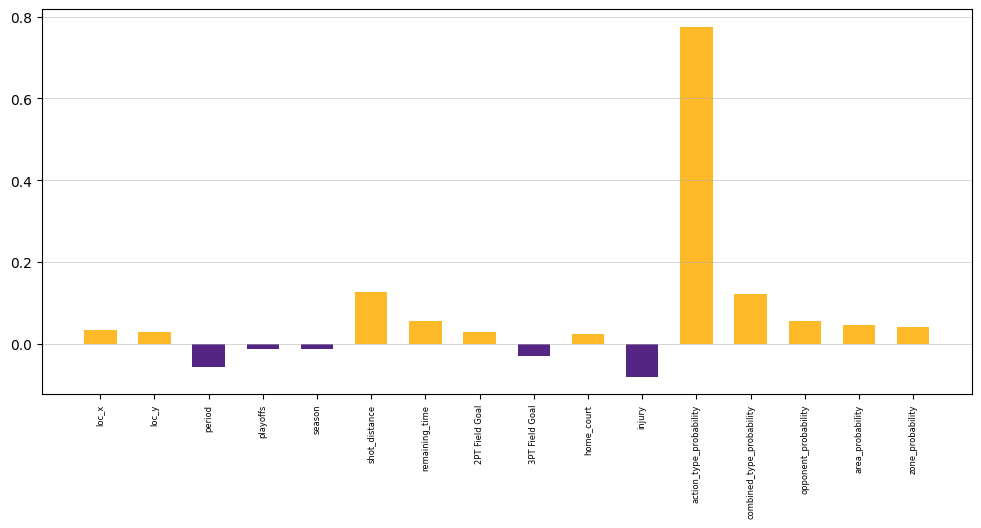

In [53]:
values = best_model.named_steps['lr'].coef_[0]

plt.figure(figsize = (10,6))
N = len(feature_names)
plt.figure(figsize=(12, 5))
plt.bar(np.arange(0, N), values, color=[lakers_orange if v >= 0 else lakers_purple for v in values], width = 0.6)
plt.xticks(np.arange(0, N), feature_names, rotation='vertical', fontsize = 6)
plt.grid(axis='y', linewidth = 0.37)

plt.show()

# <span style="font-size:20px;color:#552583">Saving model</span>

In [57]:
with open('models/lr_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(grid_search.best_estimator_, model_file)

# <span style="font-size:28px;color:#552583">2. KNN</span>

In [58]:
grid_model = Pipeline(steps=[('scaler', preprocessing.StandardScaler()), ('knn', KNeighborsClassifier())])

params = {
    'knn__n_neighbors': [6, 7, 8, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}
grid_search = GridSearchCV(grid_model, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1, return_train_score=True)
grid_search.fit(X_train, y_train)


# Get best model and parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: ", best_score)


Best parameters found:  {'knn__metric': 'manhattan', 'knn__n_neighbors': 8, 'knn__weights': 'uniform'}
Best cross-validation score:  0.6468728437199482


In [59]:
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the performance
knn_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Test Accuracy: 0.6470


# <span style="font-size:20px;color:#552583">Saving model</span>

In [60]:
with open('models/knn_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(grid_search.best_estimator_, model_file)

# <span style="font-size:28px;color:#552583"> 3. Decision trees</span>

In [61]:
grid_model = Pipeline(steps=[('scaler', preprocessing.StandardScaler()), ('dtc', DecisionTreeClassifier(random_state=7))])

params = {
    'dtc__criterion': ['gini', 'entropy'],
    'dtc__max_depth': [3, 4, 5],
    'dtc__max_features': [0.8, 0.9] 
}
grid_search = GridSearchCV(grid_model, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1, return_train_score=True)
grid_search.fit(X_train, y_train)


# Get best model and parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: ", best_score)


Best parameters found:  {'dtc__criterion': 'gini', 'dtc__max_depth': 3, 'dtc__max_features': 0.8}
Best cross-validation score:  0.6815767641986457


In [62]:
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the performance
dtc_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Test Accuracy: 0.6794


In [63]:
from sklearn import tree
import matplotlib.colors as mcolors

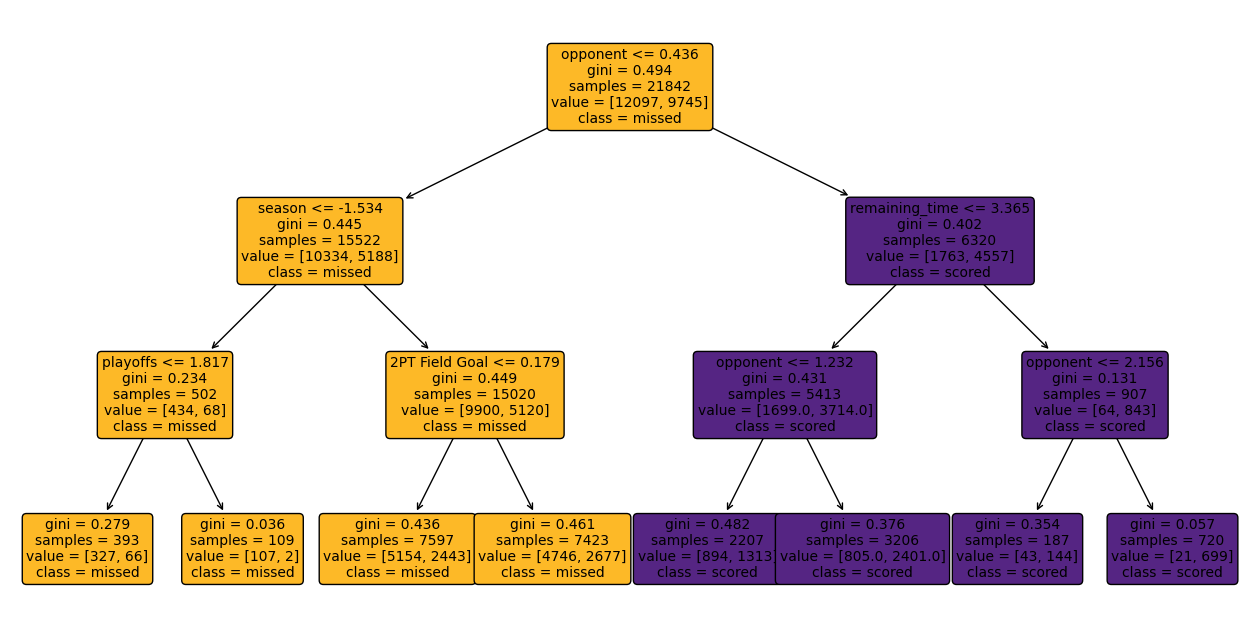

In [64]:
best_dtc_model = grid_search.best_estimator_.named_steps['dtc']
# Custom colors to match the classes
class_colors = [lakers_orange, lakers_purple]

plt.figure(figsize=(16, 8))
plot=tree.plot_tree(best_dtc_model, 
               feature_names=list(X.columns), 
               filled=True, 
               rounded=True, 
               class_names=['missed', 'scored'], fontsize=10)

ax = plt.gca()

for idx, node in enumerate(plot):
    if 'missed' in node.get_text():
        node.get_bbox_patch().set_facecolor(lakers_orange)
    elif 'scored' in node.get_text():
        node.get_bbox_patch().set_facecolor(lakers_purple)


plt.show()

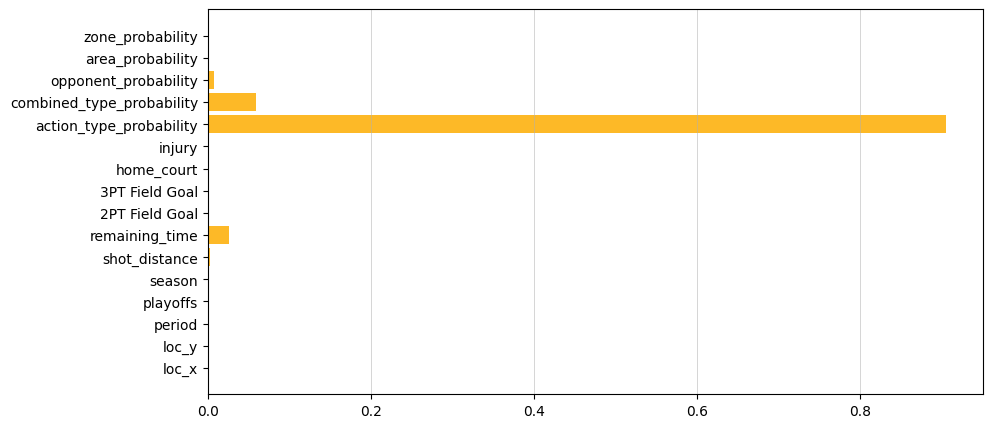

In [65]:
plt.figure(figsize=(10, 5))
plt.barh(list(feature_names), best_dtc_model.feature_importances_, color=lakers_orange)
plt.grid(axis = 'x', linewidth = 0.37)
plt.show()

# <span style="font-size:20px;color:#552583">Saving model</span>

In [69]:
with open('models/dtc_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(grid_search.best_estimator_, model_file)

# <span style="font-size:28px;color:#552583">4. Random forests</span>

In [70]:
grid_model = Pipeline(steps=[('scaler', preprocessing.StandardScaler()), ('rf', RandomForestClassifier(random_state = SEED))])

params = {
    'rf__n_estimators': [50, 70, 100],
    'rf__max_depth': [3, 5, 7]
}
grid_search = GridSearchCV(grid_model, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1, return_train_score=True)
grid_search.fit(X_train, y_train)


# Get best model and parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: ", best_score)


Best parameters found:  {'rf__max_depth': 7, 'rf__n_estimators': 100}
Best cross-validation score:  0.6824007618611647


In [73]:
y_pred = grid_search.best_estimator_.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Test Accuracy: 0.6825


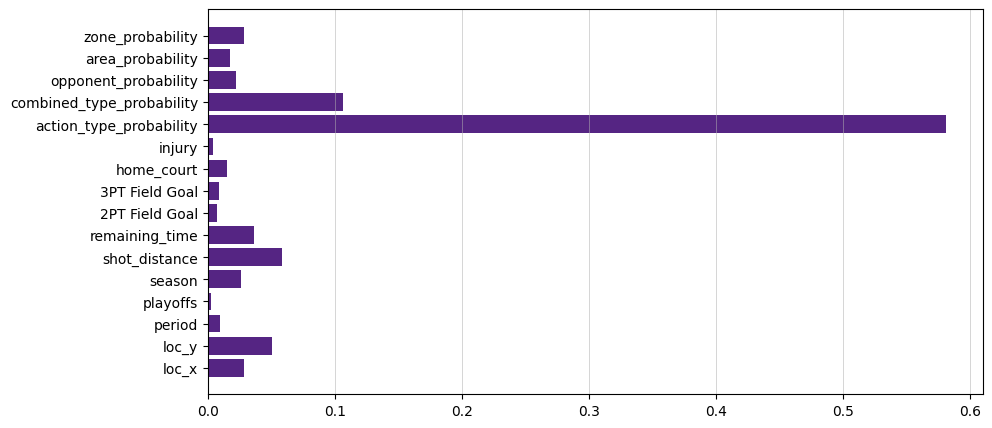

In [74]:
best_rf_model = grid_search.best_estimator_.named_steps['rf']
plt.figure(figsize=(10, 5))
plt.barh(list(feature_names), best_rf_model.feature_importances_, color=lakers_purple)
plt.grid(axis = 'x', linewidth = 0.37)
plt.show()

# <span style="font-size:20px;color:#552583">Saving model</span>

In [75]:
with open('models/rf_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(grid_search.best_estimator_, model_file)

# <span style="font-size:28px;color:#552583">5. SVC</span>

In [76]:
grid_model = Pipeline(steps=[('scaler', preprocessing.StandardScaler()), ('svc', SVC())])

params = {
     'svc__C': [0.1, 1],
    'svc__gamma': [0.01, 0.1],
    'svc__kernel': ['rbf']
    
}
grid_search = GridSearchCV(grid_model, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1, return_train_score=False)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: ", best_score)


Best parameters found:  {'svc__C': 0.1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Best cross-validation score:  0.6820346082162286


In [77]:
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the performance
svc_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Test Accuracy: 0.6796


# <span style="font-size:20px;color:#552583">Saving model</span>

In [78]:
with open('models/svc_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(grid_search.best_estimator_, model_file)

# <span style="font-size:28px;color:#552583">6. XGBoost</span>

In [79]:
grid_model = Pipeline(steps=[('scaler', preprocessing.StandardScaler()), ('xgb',  XGBClassifier(random_state=SEED,use_label_encoder=False))])

params = {
    'xgb__n_estimators': [50, 100, 150],
    'xgb__learning_rate': [0.5, 0.1],
    'xgb__max_depth': [4, 5, 6],
    'xgb__subsample': [0.7, 0.8, 0.9]
}
grid_search = GridSearchCV(grid_model, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1, return_train_score=True)
grid_search.fit(X_train, y_train)


# Get best model and parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: ", best_score)


Best parameters found:  {'xgb__learning_rate': 0.1, 'xgb__max_depth': 4, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
Best cross-validation score:  0.6824009085825292


In [80]:
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the performance
xgb_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Test Accuracy: 0.6851


# <span style="font-size:20px;color:#552583">Saving model</span>

In [81]:
with open('models/xgb_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(grid_search.best_estimator_, model_file)

# <span style="font-size:28px;color:#552583"> 7. AdaBoost </span>

In [82]:
grid_model = Pipeline(steps=[('scaler', preprocessing.StandardScaler()),
                             ('ada', AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=SEED), random_state=SEED))])

params = {
     'ada__n_estimators': [30, 60, 100],
    'ada__learning_rate': [0.05, 0.1, 1],
    'ada__estimator__max_depth': [3, 5]
}
grid_search = GridSearchCV(grid_model, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1, return_train_score=True)
grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: ", best_score)


Best parameters found:  {'ada__estimator__max_depth': 3, 'ada__learning_rate': 0.05, 'ada__n_estimators': 100}
Best cross-validation score:  0.6822177793595738


In [83]:
y_pred = grid_search.best_estimator_.predict(X_test)
ada_best = grid_search.best_estimator_.named_steps['ada']
# Evaluate the performance
ada_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Test Accuracy: 0.6830


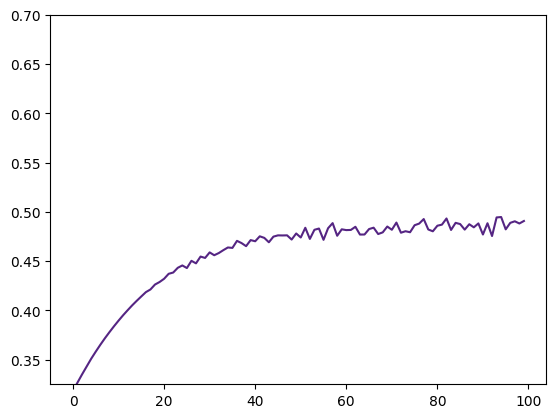

In [84]:
plt.plot(range(0, ada_best.n_estimators), ada_best.estimator_errors_, color = lakers_purple)
plt.ylim(0.325, 0.7)
plt.show()

# <span style="font-size:20px;color:#552583">Saving model</span>

In [85]:
with open('models/ada_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(grid_search.best_estimator_, model_file)

# <span style="font-size:28px;color:#552583"> 8. Naive Bayes </span>

In [87]:
from sklearn.naive_bayes import GaussianNB

# Define the pipeline with a StandardScaler and Gaussian Naive Bayes
grid_model = Pipeline(steps=[('scaler', StandardScaler()), ('nb', GaussianNB())])

# Define the hyperparameters grid
params = {
    'nb__var_smoothing': [1e-9, 1e-8, 1e-7]  # Example values for var_smoothing
}

# Perform GridSearchCV with the pipeline
grid_search = GridSearchCV(grid_model, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1, return_train_score=False)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: ", best_score)


Best parameters found:  {'nb__var_smoothing': 1e-09}
Best cross-validation score:  0.6519548420984677


In [88]:
y_pred = grid_search.best_estimator_.predict(X_test)
ada_best = grid_search.best_estimator_.named_steps['nb']
# Evaluate the performance
nb_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {nb_acc:.4f}")

Test Accuracy: 0.6558


# <span style="font-size:20px;color:#552583">Saving model</span>

In [91]:
with open('models/nb_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(grid_search.best_estimator_, model_file)

# <span style="color:#DC143C">Comparing different models</span>

In [89]:
nn_acc = 0.6835278858625162
accuracies = [log_acc, knn_acc, dtc_acc, rf_acc, svc_acc, xgb_acc, ada_acc, nn_acc, nb_acc]
labels = ["Logistic regression", "KNN", "Decision trees", "Random forests", "SVC", "XGBoost", "AdaBoost", "Neural networks", "Naive Bayes"]
print(accuracies)

[0.6801556420233463, 0.6469520103761349, 0.6793774319066148, 0.6824902723735409, 0.6796368352788587, 0.6850843060959793, 0.6830090791180286, 0.6835278858625162, 0.6557717250324254]


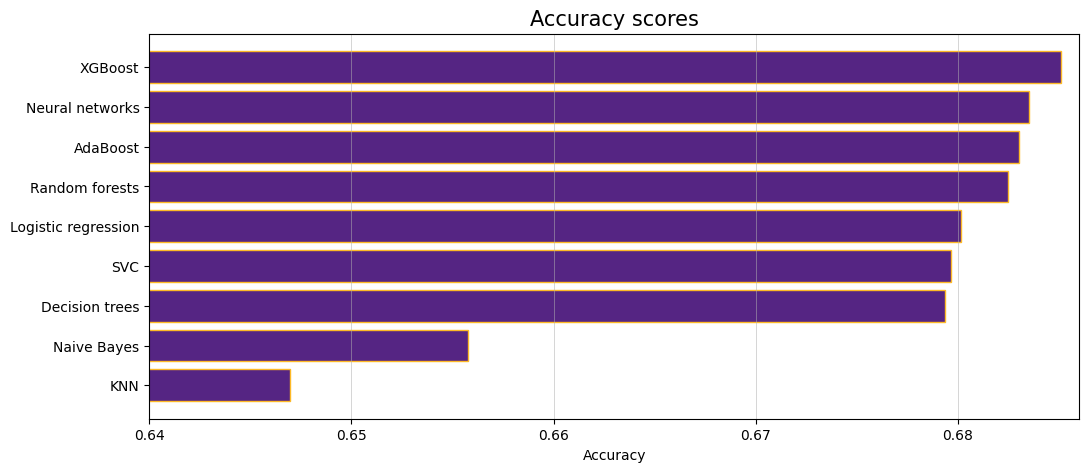

In [90]:
plt.figure(figsize = (12,5))

unsorted_list = [(labels, accuracies) for labels, accuracies in 
                  zip(accuracies, labels)]
sorted_list = sorted(unsorted_list) 

labels_sorted = []
accuracies_sorted = []

for i in sorted_list:
    labels_sorted += [i[1]]
    accuracies_sorted += [i[0]]
    
plt.title("Accuracy scores", fontsize=15)
plt.xlabel("Accuracy", fontsize=10)
plt.grid(axis = 'x', linewidth = 0.37)

plt.barh(labels_sorted, accuracies_sorted, color= lakers_purple, edgecolor=lakers_orange)
plt.xlim(0.64, 0.686)

plt.show()